## **RQ3**

### **How are short-term (MA5) and medium-term (MA20) moving averages associated with next-day returns for Canadian entertainment and media stocks?**

### Hypotheses:

##### H0: There is no statistically significant association between MA5 or MA20 values and next-day returns for Canadian entertainment and media stocks.

##### H1: There is a statistically significant association between MA5 or MA20 values and next-day returns for Canadian entertainment and media stocks.

We are testing whether today’s MA5 and MA20 can predict tomorrow’s return.
* Dependent variable (Y): Next-day return (Return_t+1)
* Independent variables (X): MA5 and MA20 from today (MA5_t, MA20_t)

Because the predictors (MA5, MA20) are contemporaneous indicators and the dependent variable is lagged by 1 day, this setup is essentially a cross-sectional regression with lagged predictors

In [21]:
import pandas as pd
data=pd.read_csv('entertainment_stocks.csv')

### **Data Preparation**

In [22]:
# Keep only the columns we need
data = data[['Date', 'Ticker', 'Company', 'Category', 'Daily_Return', 'MA5', 'MA20']]

# Convert Date and sort
data['Date'] = pd.to_datetime(data['Date'])
data = data.sort_values(['Ticker', 'Date'])

# Create Next-Day Return (lagged dependent variable)
data['Next_Return'] = data.groupby('Ticker')['Daily_Return'].shift(-1)

/var/folders/br/ng89_vjs55b9fqgsky6n1_9m0000gn/T/ipykernel_10590/4126494740.py:5: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  data['Date'] = pd.to_datetime(data['Date'])


In [23]:
data.isnull().sum()

Date              0
Ticker            0
Company           0
Category          0
Daily_Return      0
MA5              24
MA20            144
Next_Return       8
dtype: int64

In [24]:
data.shape

(10032, 8)

In [25]:
# Drop rows with missing values (from MA calculation or lagging)
data = data.dropna(subset=['MA5', 'MA20', 'Next_Return'])
data.shape

(9880, 8)

## **Predictors (X): MA5, MA20**
## **Target (Y): Next_Return**

### **Exploratory checks**

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

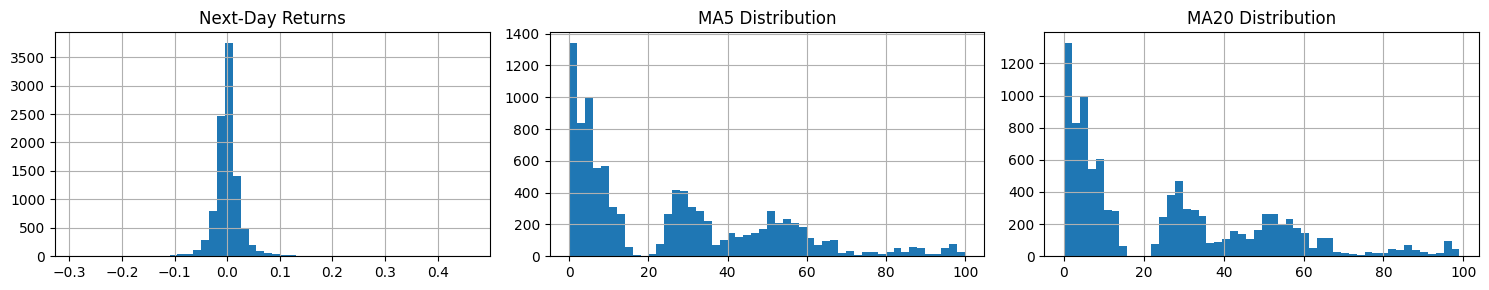

In [27]:
# Distribution comparison: Next_Return vs MA5 vs MA20
fig, axes = plt.subplots(1, 3, figsize=(15, 3))

data['Next_Return'].hist(bins=50, ax=axes[0])
axes[0].set_title("Next-Day Returns")

data['MA5'].hist(bins=50, ax=axes[1])
axes[1].set_title("MA5 Distribution")

data['MA20'].hist(bins=50, ax=axes[2])
axes[2].set_title("MA20 Distribution")

plt.tight_layout()
plt.show()

* Next-Day Returns: very narrow, centered around 0, with long thin tails (occasional ±30–40%). --> Volatile, fat-tailed distribution.
* MA5: spread out but smoother, no extreme spikes --> reflects short-term average of prices.
* MA20: even smoother, more concentrated, fewer fluctuations --> reflects medium-term average of prices.

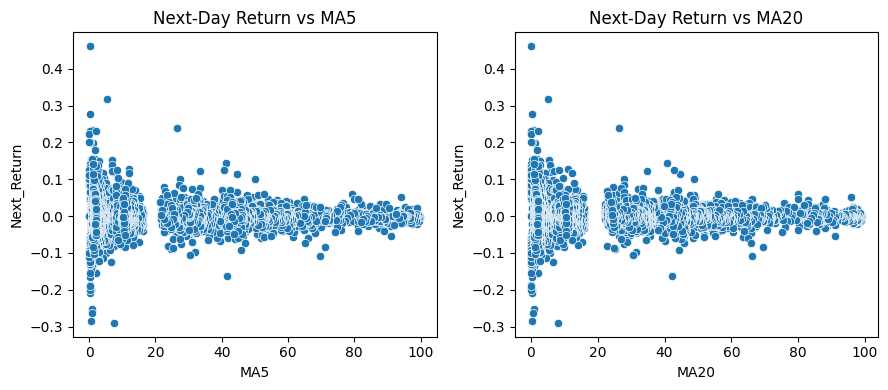

In [28]:
#Scatterplots: Next_Return vs MA5 and MA20 --> see if there’s any visible trend/relationship.

fig, axes = plt.subplots(1, 2, figsize=(9, 4))
sns.scatterplot(x='MA5', y='Next_Return', data=data, ax=axes[0])
axes[0].set_title("Next-Day Return vs MA5")

sns.scatterplot(x='MA20', y='Next_Return', data=data, ax=axes[1])
axes[1].set_title("Next-Day Return vs MA20")

plt.tight_layout()
plt.show()

Next_Return vs MA5: points are tightly clustered around zero, but there’s a faint upward spread 
--> suggests slightly positive association (higher MA5 values mildly align with higher next-day returns).

Next_Return vs MA20: distribution is similar, but the slope looks flatter or even slightly negative
--> meaning MA20 may not have the same predictive strength as MA5, or might even indicate a mean-reversion effect.

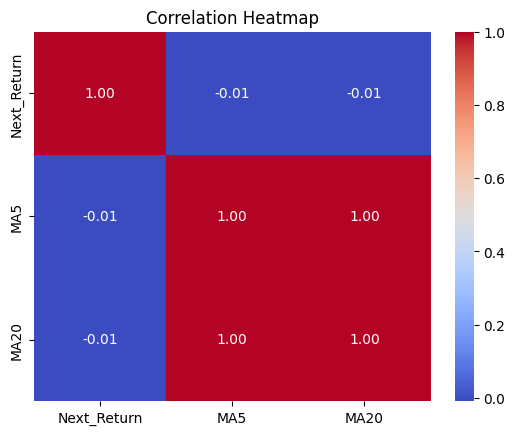

In [29]:
#Correlation heatmap between Next_Return, MA5, MA20 --> quick numeric check.
corr = data[['Next_Return', 'MA5', 'MA20']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

* Next_Return vs MA5 ≈ –0.01
* Next_Return vs MA20 ≈ –0.01
That’s basically near-zero correlation, which is expected in financial data: raw correlations don’t usually capture predictive relationships because the signal is very weak compared to noise.

There’s no obvious linear relationship by raw correlation, but we need regression to formally test the hypothesis.

## **Outliers**

Next_Return --> IQR or winsorization. Returns are fat-tailed, and extreme shocks can distort regression.

MA5 and MA20 -->They aren't outliers. They are smoothed price levels, and their skewness is natural (stock prices can be 5 CAD or 90 CAD — both are valid).

If we applied IQR here, we’d wrongly cut off high-priced firms like Rogers/Quebecor just because they trade higher than Cineplex/WildBrain.

In [30]:
# Winsorize Next_Return at 1st and 99th percentiles
lower = data['Next_Return'].quantile(0.01)
upper = data['Next_Return'].quantile(0.99)

data['Win_Next_Return'] = data['Next_Return'].clip(lower, upper)

## **Assumption Checks**

In [31]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import normal_ad

from statsmodels.stats.stattools import jarque_bera

Durbin-Watson: 2.086786174111587
Jarque-Bera: stat=4024.979, p=0.000, skew=0.288, kurt=6.073


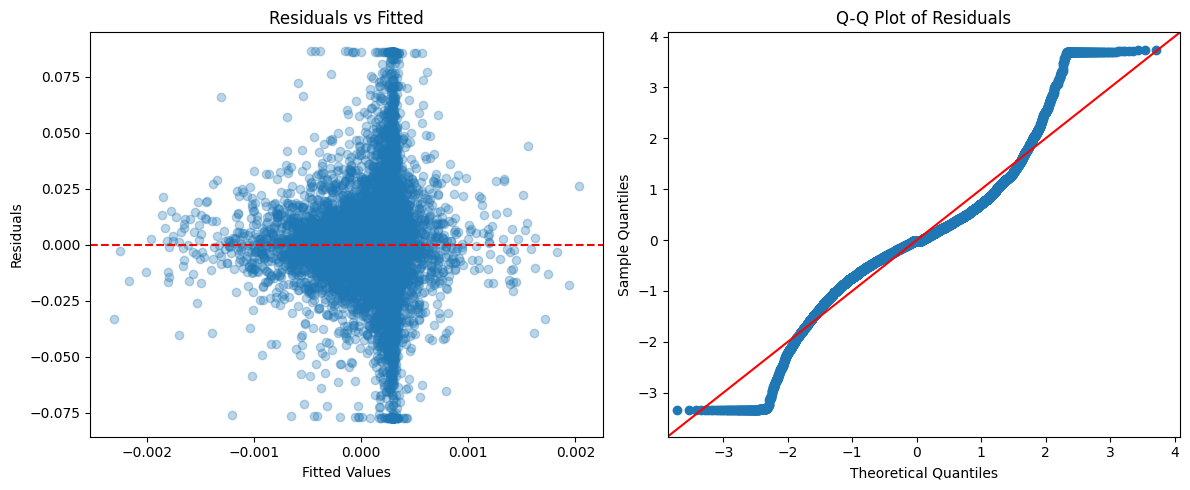

In [32]:
# --- Fit regression model ---
model = ols("Win_Next_Return ~ MA5 + MA20", data=data).fit(cov_type="HC3")
resid = model.resid
fitted = model.fittedvalues

# --- Independence ---
print("Durbin-Watson:", durbin_watson(resid))

# --- Normality (Jarque-Bera) ---
jb_stat, jb_p, skew, kurtosis = jarque_bera(resid)
print(f"Jarque-Bera: stat={jb_stat:.3f}, p={jb_p:.3f}, skew={skew:.3f}, kurt={kurtosis:.3f}")

# --- Plots side by side ---
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Residuals vs Fitted
axes[0].scatter(fitted, resid, alpha=0.3)
axes[0].axhline(0, color="red", linestyle="--")
axes[0].set_xlabel("Fitted Values")
axes[0].set_ylabel("Residuals")
axes[0].set_title("Residuals vs Fitted")

# Q-Q plot
sm.qqplot(resid, line="45", fit=True, ax=axes[1])
axes[1].set_title("Q-Q Plot of Residuals")

plt.tight_layout()
plt.show()

* Linearity: Reasonably satisfied.
* Independence: Satisfied.
* Homoscedasticity: Mild violation → fixed with HC3 robust SEs.
* Normality: Violated (heavy tails) → handled with robust SEs.

## **linear regression (OLS)**

In [33]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Fit OLS regression with robust SEs
model = ols("Win_Next_Return ~ MA5 + MA20", data=data).fit(cov_type="HC3")

# Print regression summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        Win_Next_Return   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.828
Date:                Mon, 25 Aug 2025   Prob (F-statistic):              0.161
Time:                        23:40:01   Log-Likelihood:                 23144.
No. Observations:                9880   AIC:                        -4.628e+04
Df Residuals:                    9877   BIC:                        -4.626e+04
Df Model:                           2                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0003      0.000      0.723      0.4

R² = 0.000 -->  The model explains almost none of the variation in next-day returns.
This is normal for financial return regressions — stock returns are noisy.

F-statistic p = 0.161 --> Model overall is not statistically significant at 5%.

The regression results show no strong predictive association between MA5/MA20 and next-day returns. 

Coefficients suggest very small effects (MA5 slightly negative, MA20 slightly positive), but neither is statistically significant at conventional levels. 

This means that while moving averages help describe momentum trends visually, they don’t reliably forecast next-day returns in a statistical sense for these stocks.